# Regularity pattern Detection

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from itertools import groupby
import matplotlib.pyplot as plt
import ruptures as rpt 
import changefinder
from custom_functions.gtfs_methods import get_schedule
pd.set_option('display.max_columns', None)

import logging

logging.basicConfig(
    format="%(asctime)s - %(name)s - %(levelname)s - %(module)s - : Line (%(lineno)d) - %(message)s",
    level=logging.INFO,
)

In [2]:
headway_t = pd.read_pickle("data/computed/theoretical_schedule.pkl")

calendar_dates = pd.read_csv('data/timetables/gtfs3Sept/calendar_dates.txt', sep = ",")
calendar = pd.read_csv('data/timetables/gtfs3Sept/calendar.txt', sep = ",")
trips = pd.read_csv('data/timetables/gtfs3Sept/trips.txt', sep = ",")
stops = pd.read_csv('data/timetables/gtfs3Sept/stops.txt', sep = ",")
stop_times = pd.read_csv('data/timetables/gtfs3Sept/stop_times.txt', sep = ",")
routes = pd.read_csv('data/timetables/gtfs3Sept/routes.txt', sep = ",")

In [3]:
headway_t.shape

(2820509, 31)

## Methodology

NOTE TRES IMPORTANTE : Pour lancer les modèles en dessous n'oubliez pas de drop le premier headway qui est vide du coup. La présence du NaN dans la série casse le modèle complètement.

## Custom detection model
J'ai essayé un truc handmade, qui donne des resultats okeyish vite fait bof ca passe

In [26]:
sample = headway_t[
    (headway_t.stop_id == "0089") & 
    (headway_t.route_id == 40) & 
    (headway_t.direction_id == 0) & 
    (headway_t.service_id == 233817050)]

In [27]:
sample

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,route_id,service_id,trip_headsign,direction_id,block_id,shape_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,time_seconds,headway_min
121,112361449233817050,16:14:00,16:14:00,0089,1,0,0,NaN,MONTGOMERY,NaN,50.838006,4.40897,NaN,NaN,0,37.0,40,233817050,TERVUREN STATION,0,8862028,044t0073,44,MONTGOMERY - TERVUREN STATION,NaN,0,NaN,E3BA12,000000,58440,8.0
122,112361455233817050,07:10:00,07:10:00,0089,1,0,0,NaN,MONTGOMERY,NaN,50.838006,4.40897,NaN,NaN,0,37.0,40,233817050,TERVUREN STATION,0,8862035,044t0073,44,MONTGOMERY - TERVUREN STATION,NaN,0,NaN,E3BA12,000000,25800,8.0
123,112361457233817050,08:06:00,08:06:00,0089,1,0,0,NaN,MONTGOMERY,NaN,50.838006,4.40897,NaN,NaN,0,37.0,40,233817050,TERVUREN STATION,0,8862039,044t0073,44,MONTGOMERY - TERVUREN STATION,NaN,0,NaN,E3BA12,000000,29160,8.0
124,112361463233817050,16:38:00,16:38:00,0089,1,0,0,NaN,MONTGOMERY,NaN,50.838006,4.40897,NaN,NaN,0,37.0,40,233817050,TERVUREN STATION,0,8862046,044t0073,44,MONTGOMERY - TERVUREN STATION,NaN,0,NaN,E3BA12,000000,59880,8.0
125,112361472233817050,05:19:00,05:19:00,0089,1,0,0,NaN,MONTGOMERY,NaN,50.838006,4.40897,NaN,NaN,0,37.0,40,233817050,TERVUREN STATION,0,8862028,044t0076,44,MONTGOMERY - TERVUREN STATION,NaN,0,NaN,E3BA12,000000,19140,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,112362046233817050,15:18:00,15:18:00,0089,1,0,0,NaN,MONTGOMERY,NaN,50.838006,4.40897,NaN,NaN,0,37.0,40,233817050,TERVUREN STATION,0,8862029,044t0073,44,MONTGOMERY - TERVUREN STATION,NaN,0,NaN,E3BA12,000000,55080,12.0
217,112362047233817050,15:30:00,15:30:00,0089,1,0,0,NaN,MONTGOMERY,NaN,50.838006,4.40897,NaN,NaN,0,37.0,40,233817050,TERVUREN STATION,0,8862034,044t0073,44,MONTGOMERY - TERVUREN STATION,NaN,0,NaN,E3BA12,000000,55800,12.0
218,112362119233817050,09:14:00,09:14:00,0089,1,0,0,NaN,MONTGOMERY,NaN,50.838006,4.40897,NaN,NaN,0,37.0,40,233817050,MUSEE DU TRAM,0,8862030,044t0081,44,MONTGOMERY - TERVUREN STATION,NaN,0,NaN,E3BA12,000000,33240,6.0
219,112362120233817050,09:08:00,09:08:00,0089,1,0,0,NaN,MONTGOMERY,NaN,50.838006,4.40897,NaN,NaN,0,37.0,40,233817050,MUSEE DU TRAM,0,8862039,044t0081,44,MONTGOMERY - TERVUREN STATION,NaN,0,NaN,E3BA12,000000,32880,3.0


In [28]:
fig = px.scatter(
    sample.sort_values("time_seconds"), 
    x="arrival_time", 
    y="headway_min")
fig.show()

In [29]:
ser = pd.DataFrame(sample.sort_values("time_seconds").headway_min.set_axis(sample.sort_values("time_seconds")["time_seconds"]).dropna())
ser

,headway_min
time_seconds,
20340,20.0
21300,16.0
22260,16.0
23220,16.0
24060,14.0
...,...
82740,20.0
84000,21.0
85200,20.0


In [30]:
ser.shift(1)

,headway_min
time_seconds,
20340,NaN
21300,20.0
22260,16.0
23220,16.0
24060,16.0
...,...
82740,20.0
84000,20.0
85200,21.0


In [31]:
ser["shift1-dif"] = ser - ser.shift(1)

In [32]:
fig = px.scatter(
    ser,
    y = "shift1-dif",
    x =ser.index)
fig.show()

In [33]:
ser.std()

headway_min    4.46607
shift1-dif     2.08084
dtype: float64

In [34]:
ser

,headway_min,shift1-dif
time_seconds,,
20340,20.0,NaN
21300,16.0,-4.0
22260,16.0,0.0
23220,16.0,0.0
24060,14.0,-2.0
...,...,...
82740,20.0,0.0
84000,21.0,1.0
85200,20.0,-1.0


In [35]:
groups = [list(j) for i, j in groupby(ser["shift1-dif"])]
groups_min = []
threshold = 5

clusters = []

temp = []
for group in groups:
    if len(group) < threshold:
        temp.extend(group)
    else:
        groups_min.append(temp)
        temp = []
        groups_min.append(group)
groups_min.append(temp)
        

for index, j in enumerate(groups_min):
    for i in j:
        clusters.append("cluster_" + str(index))

ser["Strict_clusters"] = clusters


In [36]:
fig = px.scatter(
    ser,
    y = "headway_min",
    x =ser.index,
    color= "Strict_clusters")
fig.show()

## Change point Detection method

Ca c'est des techniques qui viennent du monde du signal procressing. L'idée c'est de détécter les paliers d'un signal (changing points) de façon non supervisée. Ici j'ai considéré un headway comme un signal en fait. Et ca me detecte très bien les palliers de façon non supervisée. La librairie qui marche le mieux, sans trop de paramétrisation, c'est ruptures (https://centre-borelli.github.io/ruptures-docs/user-guide/detection/pelt/). Et concrètement on utilise le PELT qui lui n'a pas besoin d'un nombre de groupe prédéfini. 

https://techrando.com/2019/08/14/a-brief-introduction-to-change-point-detection-using-python/ <br>
https://medium.com/dataman-in-ai/finding-the-change-points-in-a-time-series-95a308207012

In [37]:
serie = np.array(ser["headway_min"].to_list())
serie

array([20., 16., 16., 16., 14., 11., 10.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8., 11.,  3.,  6.,  4., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 13., 11.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8., 12.,  9.,  5.,
        2.,  9.,  6.,  3., 12., 13., 15., 19., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 21., 20., 20., 20.])

### Rupture

In [38]:
signal = np.array(ser["headway_min"].to_list())

#### PELT : Linearly penalized segmentation

In [44]:
PELT = rpt.Pelt(model="rbf").fit(signal)
PELT_res = PELT.predict(pen=1)
fig = px.scatter(y=signal)
for line in PELT_res:
    fig.add_vline(x=line)
fig.show()

#### Binary segmentation

In [40]:
BINSEG = rpt.Binseg(model="rbf").fit(signal)
BINSEG_res = BINSEG.predict(pen=1)

fig = px.scatter(y=signal)
for line in BINSEG_res:
    fig.add_vline(x=line)
fig.show()

#### Sliding Window

In [19]:
WIN = rpt.Window(width=4, model="l2").fit(signal)
WIN_res = WIN.predict(pen=10)

fig = px.scatter(y=signal)
for line in WIN_res:
    fig.add_vline(x=line)
fig.show()

### Change Points Method

NameError: name 'plot_change_points' is not defined

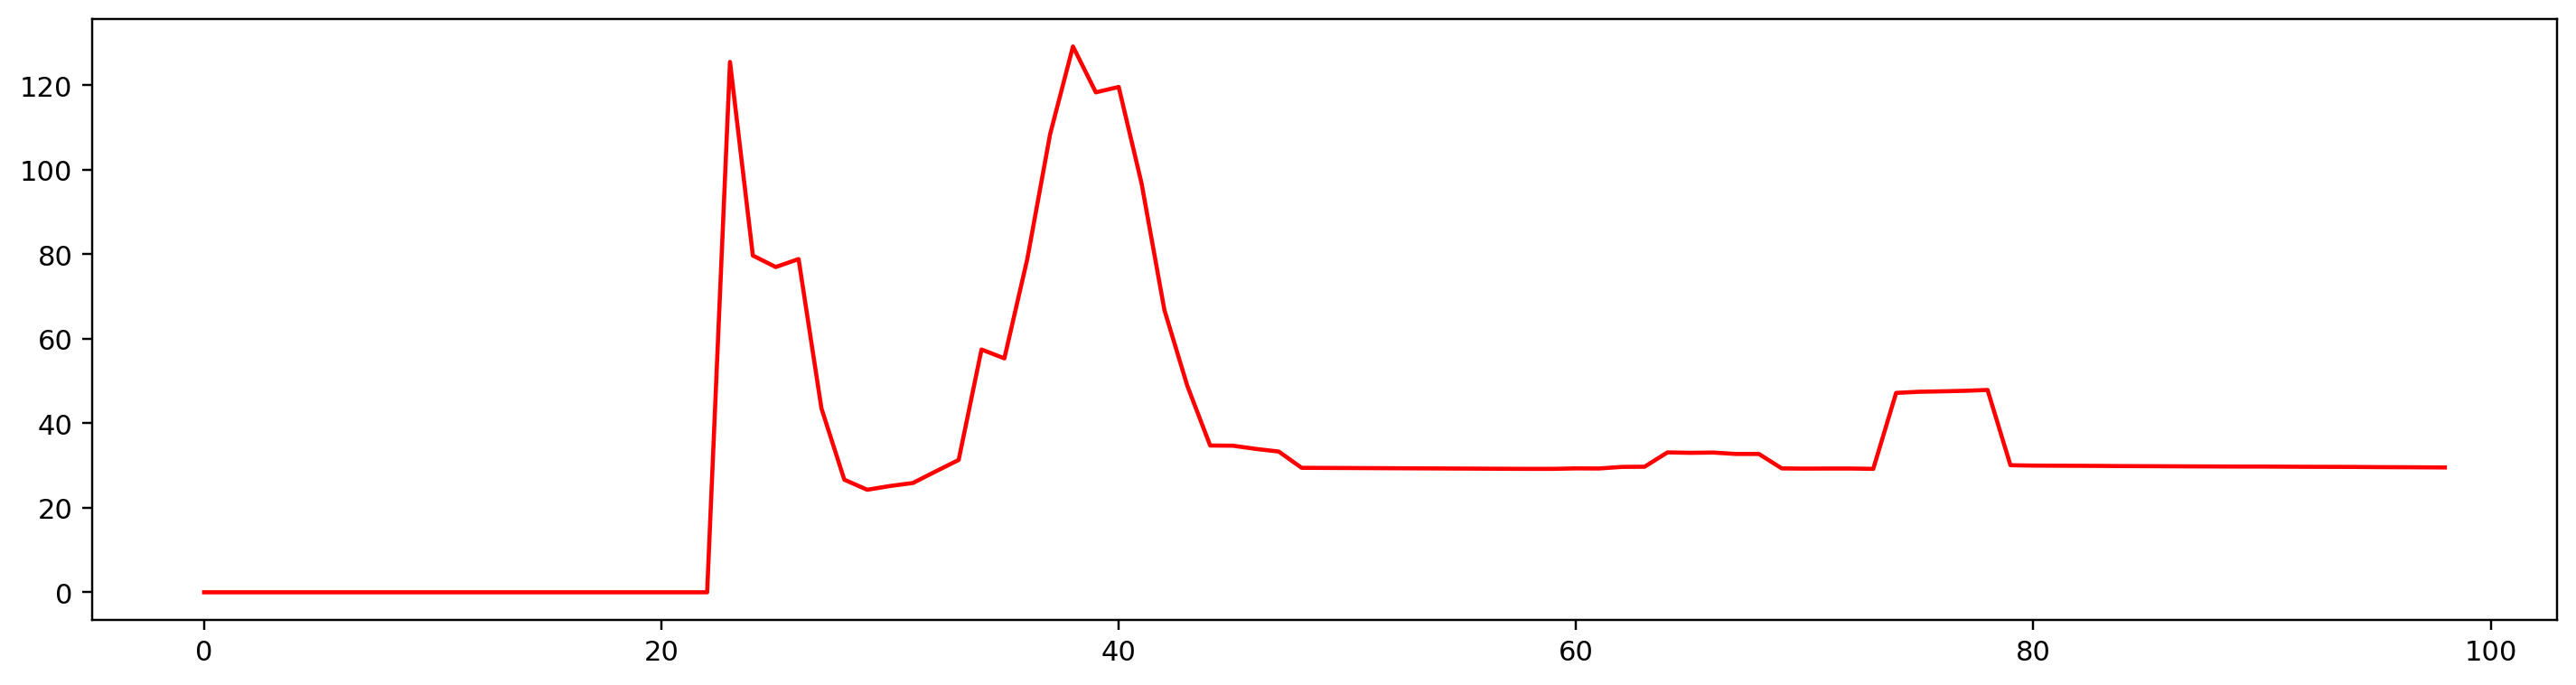

In [20]:
def findChangePoints(ts, r, order, smooth):
    '''
       r: Discounting rate
       order: AR model order
       smooth: smoothing window size T
    '''
    cf = changefinder.ChangeFinder(r=r, order=order, smooth=smooth)
    ts_score = [cf.update(p) for p in ts]
    #plt.figure(figsize=(16,4))
    #plt.plot(ts)
    plt.figure(figsize=(16,4), dpi=220)
    plt.plot(ts_score, color='red')
    return(ts_score)

ts_score1 = findChangePoints(serie, r = 0.01, order = 5, smooth = 10)
ts_change_loc2 = pd.Series(ts_score1).nlargest(5).index
plot_change_points(signal,ts_change_loc2)

## Samples

### Ligne 25 - direction 1 - Georges Henri - Weekdays

In [49]:
sample_test = get_schedule(
    headway_t,
    stops,
    25,
    1,
    stop_name= "GEORGES HENRI"
)

In [ ]:
"""
fig = px.scatter(
    sample[0].sort_values("time_seconds"), 
    x="arrival_time", 
    y="headway_min")
fig.show()
"""

'\nfig = px.scatter(\n    sample[0].sort_values("time_seconds"), \n    x="arrival_time", \n    y="headway_min")\nfig.show()\n'

In [54]:
serie_test = np.array(sample_test[0].sort_values(by="time_seconds")["headway_min"].dropna().to_list())  

In [94]:
PELT = rpt.Pelt(model="rbf").fit(serie_test)
PELT_res = PELT.predict(pen=3)
fig = px.scatter(y=serie_test)
for line in PELT_res:
    fig.add_vline(x=line)
fig.show()

### Ligne 7 - direction 1 - HEMBEEK - Weekdays

Faites attentions, la route short name elle matche pas toujours avec le vrai numéro. Ici la ligne 7 c'est la route ID 6 Lol

In [7]:
sample_test2 = get_schedule(
    headway_t,
    stops,
    6,
    0,
    stop_name= "HEEMBEEK"
)
sample_test2[0]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,route_id,service_id,trip_headsign,direction_id,block_id,shape_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,time_seconds,headway_min
2178177,113338826237534000,06:32:00,06:32:00,5771,21,0,0,NaN,HEEMBEEK,NaN,50.88881,4.374978,NaN,NaN,0,NaN,6,237534000,HEYSEL,0,8944449,007t0613,7,VANDERKINDERE - HEYSEL,NaN,0,NaN,ECE354,000000,23520,9.0
2178178,113338827237534000,06:54:00,06:54:00,5771,21,0,0,NaN,HEEMBEEK,NaN,50.88881,4.374978,NaN,NaN,0,NaN,6,237534000,HEYSEL,0,8944452,007t0613,7,VANDERKINDERE - HEYSEL,NaN,0,NaN,ECE354,000000,24840,6.0
2178179,113338828237534000,06:12:00,06:12:00,5771,21,0,0,NaN,HEEMBEEK,NaN,50.88881,4.374978,NaN,NaN,0,NaN,6,237534000,HEYSEL,0,8944453,007t0613,7,VANDERKINDERE - HEYSEL,NaN,0,NaN,ECE354,000000,22320,6.0
2178180,113338829237534000,06:40:00,06:40:00,5771,21,0,0,NaN,HEEMBEEK,NaN,50.88881,4.374978,NaN,NaN,0,NaN,6,237534000,HEYSEL,0,8944447,007t0613,7,VANDERKINDERE - HEYSEL,NaN,0,NaN,ECE354,000000,24000,4.0
2178181,113338830237534000,06:06:00,06:06:00,5771,21,0,0,NaN,HEEMBEEK,NaN,50.88881,4.374978,NaN,NaN,0,NaN,6,237534000,HEYSEL,0,8944446,007t0613,7,VANDERKINDERE - HEYSEL,NaN,0,NaN,ECE354,000000,21960,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178328,113339175237534000,21:41:00,21:41:00,5771,29,0,0,NaN,HEEMBEEK,NaN,50.88881,4.374978,NaN,NaN,0,NaN,6,237534000,HEYSEL,0,8944472,007t0611,7,VANDERKINDERE - HEYSEL,NaN,0,NaN,ECE354,000000,78060,11.0
2178329,113339524237534000,14:44:00,14:44:00,5771,21,0,0,NaN,HEEMBEEK,NaN,50.88881,4.374978,NaN,NaN,0,NaN,6,237534000,HEYSEL,0,8944467,007t0613,7,VANDERKINDERE - HEYSEL,NaN,0,NaN,ECE354,000000,53040,6.0
2178330,113339526237534000,15:47:00,15:47:00,5771,21,0,0,NaN,HEEMBEEK,NaN,50.88881,4.374978,NaN,NaN,0,NaN,6,237534000,HEYSEL,0,8944463,007t0613,7,VANDERKINDERE - HEYSEL,NaN,0,NaN,ECE354,000000,56820,7.0
2178331,113339530237534000,16:16:00,16:16:00,5771,21,0,0,NaN,HEEMBEEK,NaN,50.88881,4.374978,NaN,NaN,0,NaN,6,237534000,HEYSEL,0,8944462,007t0613,7,VANDERKINDERE - HEYSEL,NaN,0,NaN,ECE354,000000,58560,5.0


In [8]:
serie_test_2 = np.array(sample_test2[0].sort_values(by="time_seconds")["headway_min"].dropna().to_list())

In [62]:
PELT = rpt.Pelt(model="rbf").fit(serie_test_2)
PELT_res = PELT.predict(pen=2)
print(PELT_res)
fig = px.scatter(y=serie_test_2)
for line in PELT_res:
    fig.add_vline(x=line)
fig.show()

[20, 50, 80, 100, 135, 145, 155]


In [95]:
PELT = rpt.Pelt(model="rbf").fit(serie_test_2)
PELT_res = PELT.predict(pen=3)
print(PELT_res)
fig = px.scatter(y=serie_test_2)
for line in PELT_res:
    fig.add_vline(x=line)
fig.show()

[20, 50, 95, 135, 145, 155]


### Ligne 66 - Terdelt - direction 1 - Weekdays

In [10]:
sample_test3 = get_schedule(
    headway_t,
    stops,
    64,
    0,
    stop_name = "TERDELT"
)
sample_test2[0]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,route_id,service_id,trip_headsign,direction_id,block_id,shape_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,time_seconds,headway_min
2178177,113338826237534000,06:32:00,06:32:00,5771,21,0,0,NaN,HEEMBEEK,NaN,50.88881,4.374978,NaN,NaN,0,NaN,6,237534000,HEYSEL,0,8944449,007t0613,7,VANDERKINDERE - HEYSEL,NaN,0,NaN,ECE354,000000,23520,9.0
2178178,113338827237534000,06:54:00,06:54:00,5771,21,0,0,NaN,HEEMBEEK,NaN,50.88881,4.374978,NaN,NaN,0,NaN,6,237534000,HEYSEL,0,8944452,007t0613,7,VANDERKINDERE - HEYSEL,NaN,0,NaN,ECE354,000000,24840,6.0
2178179,113338828237534000,06:12:00,06:12:00,5771,21,0,0,NaN,HEEMBEEK,NaN,50.88881,4.374978,NaN,NaN,0,NaN,6,237534000,HEYSEL,0,8944453,007t0613,7,VANDERKINDERE - HEYSEL,NaN,0,NaN,ECE354,000000,22320,6.0
2178180,113338829237534000,06:40:00,06:40:00,5771,21,0,0,NaN,HEEMBEEK,NaN,50.88881,4.374978,NaN,NaN,0,NaN,6,237534000,HEYSEL,0,8944447,007t0613,7,VANDERKINDERE - HEYSEL,NaN,0,NaN,ECE354,000000,24000,4.0
2178181,113338830237534000,06:06:00,06:06:00,5771,21,0,0,NaN,HEEMBEEK,NaN,50.88881,4.374978,NaN,NaN,0,NaN,6,237534000,HEYSEL,0,8944446,007t0613,7,VANDERKINDERE - HEYSEL,NaN,0,NaN,ECE354,000000,21960,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178328,113339175237534000,21:41:00,21:41:00,5771,29,0,0,NaN,HEEMBEEK,NaN,50.88881,4.374978,NaN,NaN,0,NaN,6,237534000,HEYSEL,0,8944472,007t0611,7,VANDERKINDERE - HEYSEL,NaN,0,NaN,ECE354,000000,78060,11.0
2178329,113339524237534000,14:44:00,14:44:00,5771,21,0,0,NaN,HEEMBEEK,NaN,50.88881,4.374978,NaN,NaN,0,NaN,6,237534000,HEYSEL,0,8944467,007t0613,7,VANDERKINDERE - HEYSEL,NaN,0,NaN,ECE354,000000,53040,6.0
2178330,113339526237534000,15:47:00,15:47:00,5771,21,0,0,NaN,HEEMBEEK,NaN,50.88881,4.374978,NaN,NaN,0,NaN,6,237534000,HEYSEL,0,8944463,007t0613,7,VANDERKINDERE - HEYSEL,NaN,0,NaN,ECE354,000000,56820,7.0
2178331,113339530237534000,16:16:00,16:16:00,5771,21,0,0,NaN,HEEMBEEK,NaN,50.88881,4.374978,NaN,NaN,0,NaN,6,237534000,HEYSEL,0,8944462,007t0613,7,VANDERKINDERE - HEYSEL,NaN,0,NaN,ECE354,000000,58560,5.0


In [11]:
serie_test_3 = np.array(sample_test3[0].sort_values(by="time_seconds")["headway_min"].dropna().to_list())

In [97]:
PELT = rpt.Pelt(model="rbf").fit(serie_test_3)
PELT_res = PELT.predict(pen=2)
fig = px.scatter(y=serie_test_3)
for line in PELT_res:
    fig.add_vline(x=line)
fig.show()

In [ ]:
PELT = rpt.Pelt(model="rbf").fit(serie_test_3)
PELT_res = PELT.predict(pen=3)
fig = px.scatter(y=serie_test_3)
for line in PELT_res:
    fig.add_vline(x=line)
fig.show()

In [13]:
sample_test3[1]

('TERDELT', 64, 0, 237437001)

### Cas rare 

On a pas de rupture dans ce cas, vu que tous les points sont plus ou moins aligné. De toute façon ils sont très haut, c'est ponctualité d'office.

In [14]:
sample_test4 = get_schedule(
    headway_t,
    stops,
    59,
    0,
    stop_id = "9996",
    service_id= 238006605
)
sample_test4[0]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,route_id,service_id,trip_headsign,direction_id,block_id,shape_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,time_seconds,headway_min
2820456,113357481237592001,19:17:00,19:17:00,9996,17,1,0,NaN,MONTGOMERY,NaN,50.837483,4.406117,NaN,NaN,0,NaN,59,237592001,MONTGOMERY,0,8945621,061b0014,61,GARE DU NORD - MONTGOMERY,NaN,3,NaN,FFDC01,000000,69420,47.0
2820457,113357491237592001,18:30:00,18:30:00,9996,17,1,0,NaN,MONTGOMERY,NaN,50.837483,4.406117,NaN,NaN,0,NaN,59,237592001,MONTGOMERY,0,8945618,061b0014,61,GARE DU NORD - MONTGOMERY,NaN,3,NaN,FFDC01,000000,66600,43.0
2820458,113357493237592001,17:47:00,17:47:00,9996,17,1,0,NaN,MONTGOMERY,NaN,50.837483,4.406117,NaN,NaN,0,NaN,59,237592001,MONTGOMERY,0,8945620,061b0014,61,GARE DU NORD - MONTGOMERY,NaN,3,NaN,FFDC01,000000,64020,456.0
2820459,113357523237592001,10:11:00,10:11:00,9996,17,1,0,NaN,MONTGOMERY,NaN,50.837483,4.406117,NaN,NaN,0,NaN,59,237592001,MONTGOMERY,0,8945623,061b0014,61,GARE DU NORD - MONTGOMERY,NaN,3,NaN,FFDC01,000000,36660,46.0
2820460,113357527237592001,09:25:00,09:25:00,9996,17,1,0,NaN,MONTGOMERY,NaN,50.837483,4.406117,NaN,NaN,0,NaN,59,237592001,MONTGOMERY,0,8945624,061b0014,61,GARE DU NORD - MONTGOMERY,NaN,3,NaN,FFDC01,000000,33900,40.0
2820461,113357529237592001,08:45:00,08:45:00,9996,17,1,0,NaN,MONTGOMERY,NaN,50.837483,4.406117,NaN,NaN,0,NaN,59,237592001,MONTGOMERY,0,8945622,061b0014,61,GARE DU NORD - MONTGOMERY,NaN,3,NaN,FFDC01,000000,31500,NaN
2820462,113357544237592001,23:55:00,23:55:00,9996,17,1,0,NaN,MONTGOMERY,NaN,50.837483,4.406117,NaN,NaN,0,NaN,59,237592001,MONTGOMERY,0,8945628,061b0014,61,GARE DU NORD - MONTGOMERY,NaN,3,NaN,FFDC01,000000,86100,20.0
2820463,113357546237592001,23:35:00,23:35:00,9996,17,1,0,NaN,MONTGOMERY,NaN,50.837483,4.406117,NaN,NaN,0,NaN,59,237592001,MONTGOMERY,0,8945627,061b0014,61,GARE DU NORD - MONTGOMERY,NaN,3,NaN,FFDC01,000000,84900,79.0
2820464,113357559237592001,24:15:00,24:15:00,9996,17,1,0,NaN,MONTGOMERY,NaN,50.837483,4.406117,NaN,NaN,0,NaN,59,237592001,MONTGOMERY,0,8945625,061b0014,61,GARE DU NORD - MONTGOMERY,NaN,3,NaN,FFDC01,000000,87300,20.0
2820465,113357560237592001,22:16:00,22:16:00,9996,17,1,0,NaN,MONTGOMERY,NaN,50.837483,4.406117,NaN,NaN,0,NaN,59,237592001,MONTGOMERY,0,8945626,061b0014,61,GARE DU NORD - MONTGOMERY,NaN,3,NaN,FFDC01,000000,80160,138.0


In [20]:
serie_test_4 = np.array(sample_test4[0].sort_values(by="time_seconds")["headway_min"].dropna().to_list())

In [21]:
PELT = rpt.Pelt(model="rbf").fit(serie_test_4)
PELT_res = PELT.predict(pen=2)
fig = px.scatter(y=serie_test_4)
for line in PELT_res:
    fig.add_vline(x=line)
fig.show()

In [98]:
PELT = rpt.Pelt(model="rbf").fit(serie_test_4)
PELT_res = PELT.predict(pen=3)
fig = px.scatter(y=serie_test_4)
for line in PELT_res:
    fig.add_vline(x=line)
fig.show()

### Bus 71

In [63]:
routes[routes.route_short_name =="71"]

,route_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
56,65,71,DE BROUCKERE - DELTA,NaN,3,NaN,4C8B33,000000


In [86]:
sample_test5 = get_schedule(
    headway_t,
    stops,
    65,
    0,
    stop_name= "BUYL"
)
sample_test5[0]

Exception: The transport 65 at stop BUYL is going through several stop_ids[None, 2351,...]. Can you investigate ?

In [87]:
sample_test5 = get_schedule(
    headway_t,
    stops,
    65,
    0,
    stop_id= "2351"
)
sample_test5[0]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,route_id,service_id,trip_headsign,direction_id,block_id,shape_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,time_seconds,headway_min
871981,113334769238006605,12:31:00,12:31:00,2351,17,0,0,NaN,BUYL,NaN,50.818914,4.378791,NaN,NaN,0,NaN,65,238006605,BUYL,0,8951419,071b0206,71,DE BROUCKERE - DELTA,NaN,3,NaN,4C8B33,000000,45060,10.0
871982,113334780238006605,11:30:00,11:30:00,2351,17,0,0,NaN,BUYL,NaN,50.818914,4.378791,NaN,NaN,0,NaN,65,238006605,BUYL,0,8951412,071b0206,71,DE BROUCKERE - DELTA,NaN,3,NaN,4C8B33,000000,41400,10.0
871983,113334781238006605,11:40:00,11:40:00,2351,17,0,0,NaN,BUYL,NaN,50.818914,4.378791,NaN,NaN,0,NaN,65,238006605,BUYL,0,8951417,071b0206,71,DE BROUCKERE - DELTA,NaN,3,NaN,4C8B33,000000,42000,10.0
871984,113334782238006605,11:50:00,11:50:00,2351,17,0,0,NaN,BUYL,NaN,50.818914,4.378791,NaN,NaN,0,NaN,65,238006605,BUYL,0,8951415,071b0206,71,DE BROUCKERE - DELTA,NaN,3,NaN,4C8B33,000000,42600,10.0
871985,113334783238006605,12:00:00,12:00:00,2351,17,0,0,NaN,BUYL,NaN,50.818914,4.378791,NaN,NaN,0,NaN,65,238006605,BUYL,0,8951413,071b0206,71,DE BROUCKERE - DELTA,NaN,3,NaN,4C8B33,000000,43200,10.0
871986,113334784238006605,12:10:00,12:10:00,2351,17,0,0,NaN,BUYL,NaN,50.818914,4.378791,NaN,NaN,0,NaN,65,238006605,BUYL,0,8951418,071b0206,71,DE BROUCKERE - DELTA,NaN,3,NaN,4C8B33,000000,43800,10.0
871987,113334785238006605,12:21:00,12:21:00,2351,17,0,0,NaN,BUYL,NaN,50.818914,4.378791,NaN,NaN,0,NaN,65,238006605,BUYL,0,8951414,071b0206,71,DE BROUCKERE - DELTA,NaN,3,NaN,4C8B33,000000,44460,11.0
871988,113334791238006605,10:29:00,10:29:00,2351,17,0,0,NaN,BUYL,NaN,50.818914,4.378791,NaN,NaN,0,NaN,65,238006605,BUYL,0,8951417,071b0206,71,DE BROUCKERE - DELTA,NaN,3,NaN,4C8B33,000000,37740,10.0
871989,113334792238006605,10:39:00,10:39:00,2351,17,0,0,NaN,BUYL,NaN,50.818914,4.378791,NaN,NaN,0,NaN,65,238006605,BUYL,0,8951415,071b0206,71,DE BROUCKERE - DELTA,NaN,3,NaN,4C8B33,000000,38340,10.0
871990,113334793238006605,10:49:00,10:49:00,2351,17,0,0,NaN,BUYL,NaN,50.818914,4.378791,NaN,NaN,0,NaN,65,238006605,BUYL,0,8951413,071b0206,71,DE BROUCKERE - DELTA,NaN,3,NaN,4C8B33,000000,38940,10.0


In [100]:
serie_test_5 = np.array(sample_test5[0].sort_values(by="time_seconds")["headway_min"].dropna().to_list())
PELT = rpt.Pelt(model="rbf").fit(serie_test_5)
PELT_res = PELT.predict(pen=2)
fig = px.scatter(y=serie_test_5)
for line in PELT_res:
    fig.add_vline(x=line)
fig.show()

In [85]:
sample_test6 = get_schedule(
    headway_t,
    stops,
    65,
    0,
    stop_id= "2397"
)
sample_test6[0]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,route_id,service_id,trip_headsign,direction_id,block_id,shape_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,time_seconds,headway_min
896511,113178512236961060,06:10:00,06:10:00,2397,14,0,0,NaN,BUYL,NaN,50.817442,4.380672,NaN,NaN,0,NaN,65,236961060,DELTA,0,8927325,071b0196,71,DE BROUCKERE - DELTA,NaN,3,NaN,4C8B33,000000,22200,20.0
896512,113178514236961060,09:04:00,09:04:00,2397,14,0,0,NaN,BUYL,NaN,50.817442,4.380672,NaN,NaN,0,NaN,65,236961060,DELTA,0,8927331,071b0196,71,DE BROUCKERE - DELTA,NaN,3,NaN,4C8B33,000000,32640,5.0
896513,113178517236961060,12:40:00,12:40:00,2397,14,0,0,NaN,BUYL,NaN,50.817442,4.380672,NaN,NaN,0,NaN,65,236961060,DELTA,0,8927333,071b0196,71,DE BROUCKERE - DELTA,NaN,3,NaN,4C8B33,000000,45600,7.0
896514,113178519236961060,14:22:00,14:22:00,2397,14,0,0,NaN,BUYL,NaN,50.817442,4.380672,NaN,NaN,0,NaN,65,236961060,DELTA,0,8927333,071b0196,71,DE BROUCKERE - DELTA,NaN,3,NaN,4C8B33,000000,51720,6.0
896515,113178521236961060,16:13:00,16:13:00,2397,14,0,0,NaN,BUYL,NaN,50.817442,4.380672,NaN,NaN,0,NaN,65,236961060,DELTA,0,8927325,071b0196,71,DE BROUCKERE - DELTA,NaN,3,NaN,4C8B33,000000,58380,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896690,113180630236961060,25:33:00,25:33:00,2397,14,0,0,NaN,BUYL,NaN,50.817442,4.380672,NaN,NaN,0,NaN,65,236961060,DELTA,0,8927325,071b0194,71,DE BROUCKERE - DELTA,NaN,3,NaN,4C8B33,000000,91980,20.0
896691,113180631236961060,25:53:00,25:53:00,2397,14,0,0,NaN,BUYL,NaN,50.817442,4.380672,NaN,NaN,0,NaN,65,236961060,DELTA,0,8927340,071b0194,71,DE BROUCKERE - DELTA,NaN,3,NaN,4C8B33,000000,93180,20.0
896692,113180632236961060,26:23:00,26:23:00,2397,14,0,0,NaN,BUYL,NaN,50.817442,4.380672,NaN,NaN,0,NaN,65,236961060,DELTA,0,8927335,071b0194,71,DE BROUCKERE - DELTA,NaN,3,NaN,4C8B33,000000,94980,30.0
896693,113180633236961060,26:53:00,26:53:00,2397,14,0,0,NaN,BUYL,NaN,50.817442,4.380672,NaN,NaN,0,NaN,65,236961060,DELTA,0,8927325,071b0194,71,DE BROUCKERE - DELTA,NaN,3,NaN,4C8B33,000000,96780,30.0


In [102]:
serie_test_6 = np.array(sample_test6[0].sort_values(by="time_seconds")["headway_min"].dropna().to_list())
PELT = rpt.Pelt(model="rbf").fit(serie_test_6)
PELT_res = PELT.predict(pen=2)
fig = px.scatter(y=serie_test_6)
for line in PELT_res:
    fig.add_vline(x=line)
fig.show()

In [101]:
serie_test_6 = np.array(sample_test6[0].sort_values(by="time_seconds")["headway_min"].dropna().to_list())
PELT = rpt.Pelt(model="rbf").fit(serie_test_6)
PELT_res = PELT.predict(pen=3)
fig = px.scatter(y=serie_test_6)
for line in PELT_res:
    fig.add_vline(x=line)
fig.show()

### Erreur bizarre

In [23]:
sample_test6 = get_schedule(
    headway_t,
    stops,
    13,
    0,
    stop_id= "0470F",
    service_id= 233898050
)
sample_test6[0]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,route_id,service_id,trip_headsign,direction_id,block_id,shape_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,time_seconds,headway_min
3164,113191670236963001,09:39:00,09:39:00,0470F,1,0,1,NaN,SIMONIS,NaN,50.863666,4.329612,NaN,NaN,0,NaN,13,236963001,GUILL. DE GREEF,0,8927354,019t0104,19,GROOT-BIJGAARDEN - DE WAND,NaN,0,NaN,DE3B21,FFFFFF,34740,NaN
3165,113191671236963001,09:48:00,09:48:00,0470F,1,0,1,NaN,SIMONIS,NaN,50.863666,4.329612,NaN,NaN,0,NaN,13,236963001,GUILL. DE GREEF,0,8927357,019t0104,19,GROOT-BIJGAARDEN - DE WAND,NaN,0,NaN,DE3B21,FFFFFF,35280,9.0
3166,113191773236963001,18:52:00,18:52:00,0470F,1,0,1,NaN,SIMONIS,NaN,50.863666,4.329612,NaN,NaN,0,NaN,13,236963001,GUILL. DE GREEF,0,8927356,019t0104,19,GROOT-BIJGAARDEN - DE WAND,NaN,0,NaN,DE3B21,FFFFFF,67920,514.0
3167,113191774236963001,19:22:00,19:22:00,0470F,1,0,1,NaN,SIMONIS,NaN,50.863666,4.329612,NaN,NaN,0,NaN,13,236963001,GUILL. DE GREEF,0,8927359,019t0104,19,GROOT-BIJGAARDEN - DE WAND,NaN,0,NaN,DE3B21,FFFFFF,69720,30.0
3168,113203343236963001,10:18:00,10:18:00,0470F,1,0,1,NaN,SIMONIS,NaN,50.863666,4.329612,NaN,NaN,0,NaN,13,236963001,GUILL. DE GREEF,0,8927353,019t0104,19,GROOT-BIJGAARDEN - DE WAND,NaN,0,NaN,DE3B21,FFFFFF,37080,30.0


In [21]:
serie_test_6 = np.array(sample_test6[0].iloc[:2].sort_values(by="time_seconds")["headway_min"].dropna().to_list())
PELT = rpt.Pelt(model="rbf").fit(serie_test_6)
PELT_res = PELT.predict(pen=3)
print(PELT_res)
fig = px.scatter(y=serie_test_6)
for line in PELT_res:
    fig.add_vline(x=line)
fig.show()

/Users/mjdaoudi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning:

Mean of empty slice.

/Users/mjdaoudi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars



BadSegmentationParameters: 

In [8]:
g = headway_t.groupby(
    by = ['stop_id', "route_id", "direction_id", "service_id"]
)

In [26]:
g.get_group(('0470F', 13, 0, 233898050))

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,route_id,service_id,trip_headsign,direction_id,block_id,shape_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,time_seconds,headway_min
3163,112820672233898050,18:47:00,18:47:00,0470F,1,0,1,NaN,SIMONIS,NaN,50.863666,4.329612,NaN,NaN,0,NaN,13,233898050,GUILL. DE GREEF,0,8900076,019t0104,19,GROOT-BIJGAARDEN - DE WAND,NaN,0,NaN,DE3B21,FFFFFF,67620,NaN
